In [2]:
#Loading the folder present in Google drive to Colab
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#Unzipping the contents from Google drive onto Colab
!unzip /content/drive/My\ Drive/Prethesis/test_18.zip # Test 3D MRI images
!unzip /content/drive/My\ Drive/Prethesis/AD_CN_380.zip # Load training data
#!unzip /content/drive/My\ Drive/Prethesis/weight_july_8_2Dsingle.h5 #Load weights of trained 2D CNN model
#!unzip /content/drive/My\ Drive/Prethesis/weights_july_8_3D.h5 #Load weights of trained 3D CNN model

Archive:  /content/drive/My Drive/Prethesis/test_18.zip
   creating: test_18/
  inflating: test_18/C_0021_011.nii  
  inflating: test_18/C_0089_073.nii  
  inflating: test_18/C_0295_002.nii  
  inflating: test_18/C_0311_073.nii  
  inflating: test_18/C_0413_002.nii  
  inflating: test_18/C_1195_941.nii  
  inflating: test_18/D_4001_037.nii  
  inflating: test_18/D_4009_016.nii  
  inflating: test_18/D_4024_031.nii  
  inflating: test_18/D_4039_014.nii  
  inflating: test_18/D_4089_094.nii  
  inflating: test_18/D_4136_003.nii  
  inflating: test_18/Late_4035_023.nii  
  inflating: test_18/Late_4042_031.nii  
  inflating: test_18/Late_4053_141.nii  
  inflating: test_18/Late_4057_072.nii  
  inflating: test_18/Late_4058_014.nii  
  inflating: test_18/Late_4061_068.nii  
Archive:  /content/drive/My Drive/Prethesis/AD_CN_380.zip
   creating: AD_CN_380/
  inflating: AD_CN_380/mwp1AD_4152_003_MR_MT1__GradWarp__N3m_Br_20110910140223979_S120806_I255415.nii  
  inflating: AD_CN_380/mwp1AD_4153

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # model will be trained on GPU 0

#!pip install --upgrade scipy==1.2.1 # to fix import imresize error in keras-vis libraby
#!pip install git+https://github.com/raghakot/keras-vis.git --upgrade   # Load Keras-vis library

import os
from keras.utils import to_categorical
from keras.layers import Input,Dense,Flatten,Dropout,merge,Conv3D,MaxPooling3D,Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential,load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K

from keras import activations
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay, visualize_cam

import numpy as np
import scipy.misc
from skimage.transform import resize
import numpy.random as rng
from PIL import Image
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import math
import glob
import time
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

Using TensorFlow backend.


In [0]:
ff = glob.glob('AD_CN_380/*')

In [3]:

images=[]
labels =[]

for f in range(len(ff)):
  a = nib.load(ff[f])
  a = a.get_data()
  a = a[:,57:80,:]
  a = np.nan_to_num(a)       # normalising to (0-1) and then normalising to 0 mean and 1 std
  m = np.max(a)
  mi = np.min(a)
  a = (a - mi) / (m - mi)
  a = (a - a.mean())/a.std()
  #a =a.transpose(0,2,1)
  if('mwp1HC' in os.path.basename(ff[f])):
        images.append((a))
        label=0
        labels.append(label)
  else:
    images.append((a))
    label=1
    labels.append(label)
labels = np.asarray(labels)
labels = to_categorical(labels)
images = np.asarray(images) 

"\n\n  for i in range(a.shape[2]):\n      if('mwp1HC' in os.path.basename(ff[f])):\n        images.append((a[:,:,i]))\n        label=0\n        labels.append(label)\n      else:\n        images.append((a[:,:,i]))\n        label=1\n        labels.append(label)\nlabels = np.asarray(labels)\nlabels = to_categorical(labels)\nimages = np.asarray(images)\n"

In [0]:
images = images.reshape(-1, 121,23,121,1) # Reshaping input to feed into conv net

In [0]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,labels,test_size=0.2,stratify = labels,random_state=19)  #Test train split

In [3]:
#3D convnet model

batch_size = 20 #20
epochs = 60 #60
input_img = Input(shape = (121, 23, 121,1))

def model(input_img):
    conv1 = Conv3D(5, (3, 3, 3), padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1) #14 x 14 x 32
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(rate = 0.5)(conv1)
    
    conv2 = Conv3D(5, (3, 3, 3), padding='same',activation='relu')(conv1) #28 x 28 x 32
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2) #14 x 14 x 32
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(rate = 0.5)(conv2)
    
    conv3 = Conv3D(5, (3, 3, 3), padding='same',activation='relu')(conv2) #14 x 14 x 64
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3) #7 x 7 x 64
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(rate=0.5)(conv3)
    
    conv3 = Flatten()(conv3)
    #relu2 = Activation('relu')(flattened)
    
    #dense = Dense(100, activation='relu')(flattened) # 28 x 28 x 1
    dense = Dense(2, activation='softmax')(conv3) # 28 x 28 x 1
    return dense

W0710 00:12:05.968276 139785585670016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 00:12:06.000305 139785585670016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [4]:
model = Model(input_img, model(input_img))
model.compile(loss='categorical_crossentropy', optimizer = Adam(), metrics=['accuracy'])
#with adam optimiser lr = 0.001
model.summary()

W0710 00:12:06.027015 139785585670016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 00:12:06.155284 139785585670016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0710 00:12:06.193930 139785585670016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0710 00:12:06.595435 139785585670016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimize

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 121, 23, 121, 1)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 121, 23, 121, 5)   140       
_________________________________________________________________
batch_normalization_1 (Batch (None, 121, 23, 121, 5)   20        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 60, 11, 60, 5)     0         
_________________________________________________________________
activation_1 (Activation)    (None, 60, 11, 60, 5)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 11, 60, 5)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 11, 60, 5)     680       
__________

In [33]:
%%time

# fit model
model_train = model.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 304 samples, validate on 76 samples
Epoch 1/60
304/304 [==============================] - 4s 13ms/step - loss: 2.1138 - acc: 0.5625 - val_loss: 0.8278 - val_acc: 0.5395
Epoch 2/60
304/304 [==============================] - 2s 6ms/step - loss: 1.9212 - acc: 0.5428 - val_loss: 0.7999 - val_acc: 0.5395
Epoch 3/60
304/304 [==============================] - 2s 6ms/step - loss: 1.6799 - acc: 0.5099 - val_loss: 0.6725 - val_acc: 0.5395
Epoch 4/60
304/304 [==============================] - 2s 6ms/step - loss: 1.6609 - acc: 0.5033 - val_loss: 0.7312 - val_acc: 0.5395
Epoch 5/60
304/304 [==============================] - 2s 6ms/step - loss: 1.3292 - acc: 0.5526 - val_loss: 0.6964 - val_acc: 0.5789
Epoch 6/60
304/304 [==============================] - 2s 6ms/step - loss: 1.4082 - acc: 0.5362 - val_loss: 0.6482 - val_acc: 0.6053
Epoch 7/60
304/304 [==============================] - 2s 6ms/step - loss: 1.1765 - acc: 0.5592 - val_loss: 0.6337 - val_acc: 0.6842
Epoch 8/60
304/304 [==========

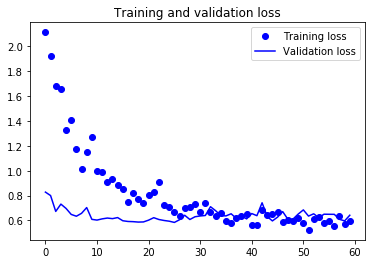

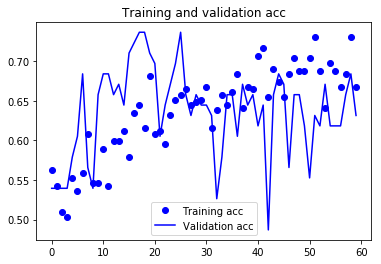

Mean training accuracy 0.637171 
Mean validation accuracy 0.637281


In [34]:
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
acc = model_train.history['acc']
val_acc = model_train.history['val_acc']
epochs = range(60)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()
acc = np.asarray(acc).mean()
val_acc = np.asarray(val_acc).mean() 
print('Mean training accuracy %f ' % acc)
print('Mean validation accuracy %f' % val_acc)

In [0]:
pred = model.predict(valid_X)


In [0]:
#save and load model
#model = model.save_weights('weights_july_8_3D.h5')
#model = Model(input_img, model(input_img))
model.load_weights('weights_july_8_3D.h5')

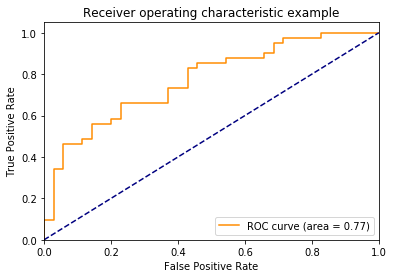

In [36]:
#change train to valid

# Compute ROC curve and ROC area for each class
#a = to_categorical(pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(valid_ground[:, i], pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(valid_ground.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#Plot of a ROC curve for a specific class

plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
#Custom colormap 

# Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
cmap = plt.get_cmap('seismic')
colors_AD = cmap(np.linspace(0.5, 1, cmap.N ))
# Create a new colormap from those colors
cmap_AD = LinearSegmentedColormap.from_list('Upper Half', colors_AD)

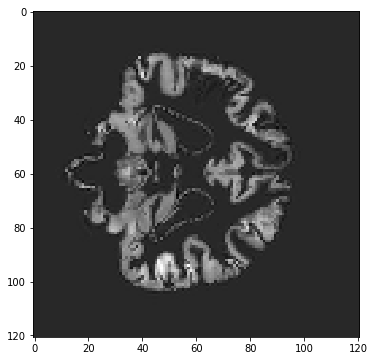

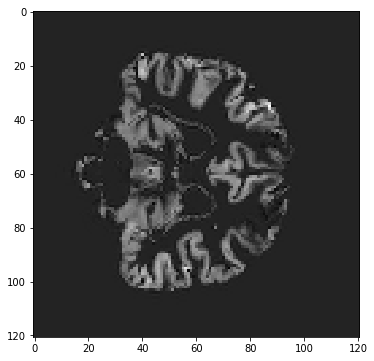

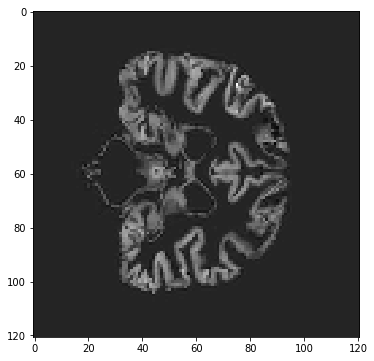

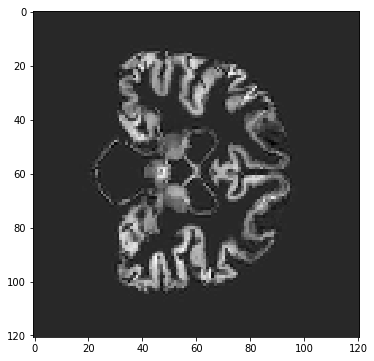

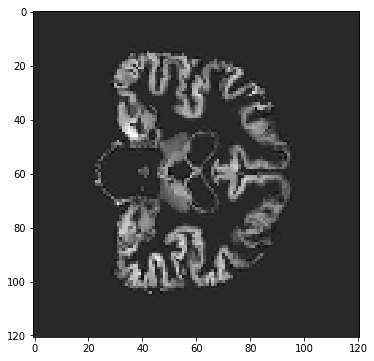

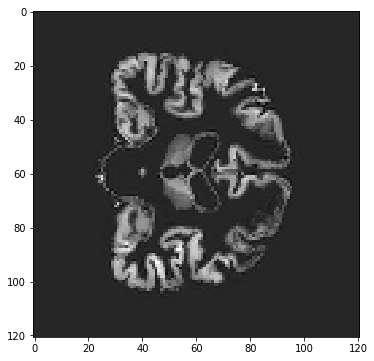

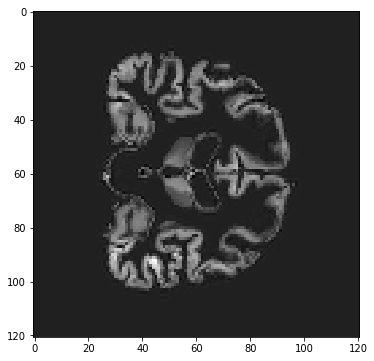

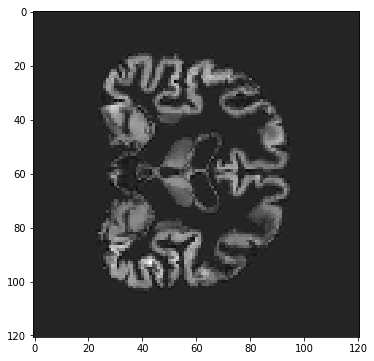

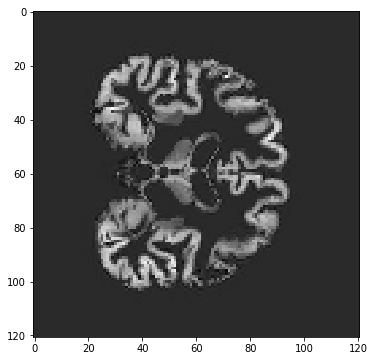

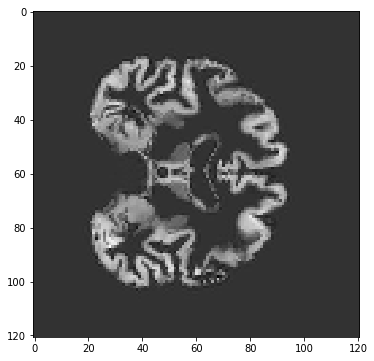

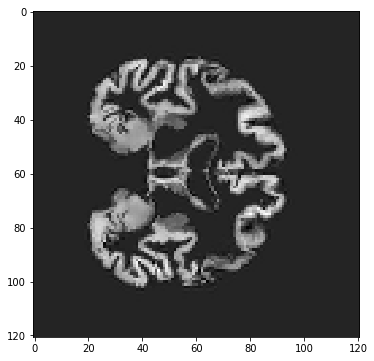

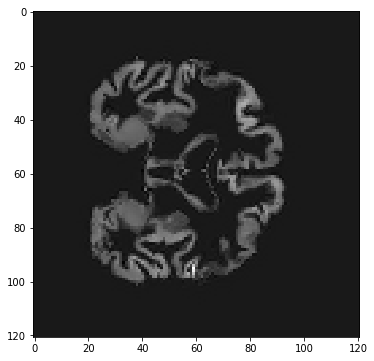

In [12]:
# Input Test image for visualization

imag = []
plt.rcParams['figure.figsize'] = (18, 6)
#ff_t = glob.glob('test_18/*')
ff_t = glob.glob('vis_ad_scans/*')
test_img = nib.load(ff_t[4])
#test_img = nib.load('')
test_img = test_img.get_data()
test_img = test_img[:,57:80,:]
test_img = np.nan_to_num(test_img)       # normalising to (0-1) and then normalising to 0 mean and 1 std
m = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (m - mi)
test_img = (test_img - test_img.mean())/test_img.std()
#test_img =test_img.transpose(0,2,1)
#imag.append(test_img)
#imag=np.asarray(imag)
#test_img = resize(test_img,(242,242))
#coronal_slices = len(test_img[2,0])
for i in range(0,23,2):
  plt.figure()
#  a = 0
  a = test_img[:,i,:]
  #a = np.rot90(a)
  #a = np.fliplr(a)
  plt.imshow(a, cmap='gray')
  
#t_img = a.reshape(242,242)

In [0]:
layer_idx = utils.find_layer_idx(model, 'dense_1')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

#To visualize activation over final dense layer outputs,we need to switch the softmax activation out for linear,
#since gradient of output node will depend on all the other node activations https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/activation_maximization.ipynb

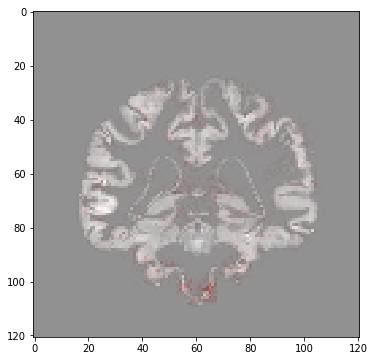

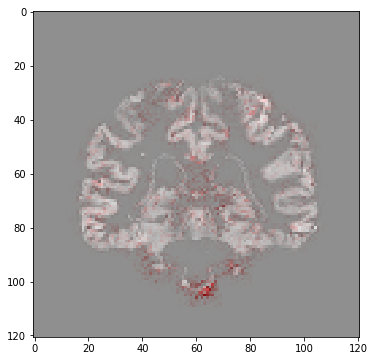

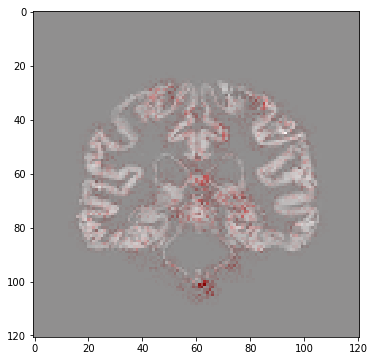

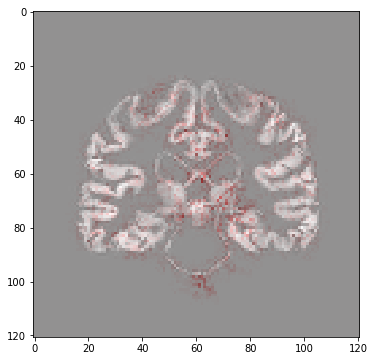

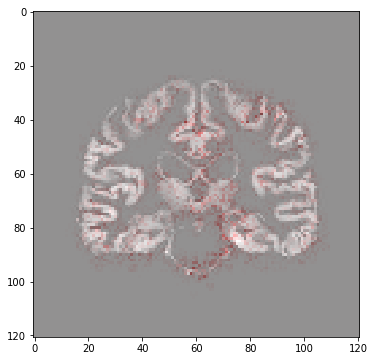

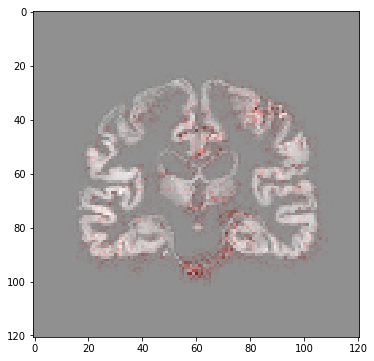

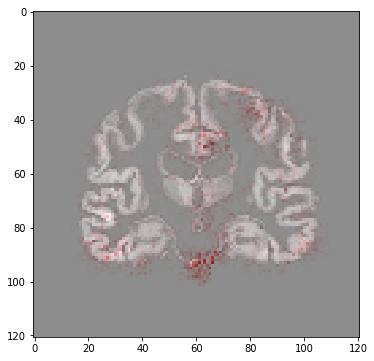

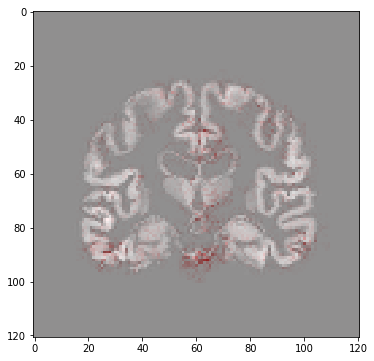

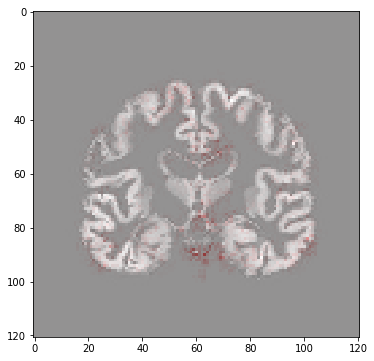

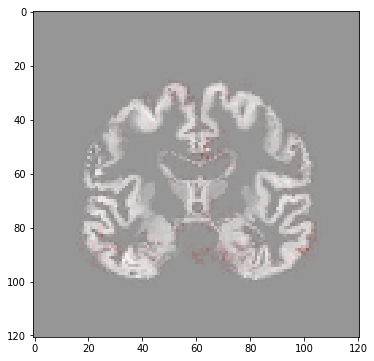

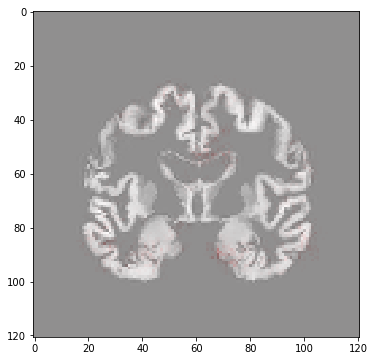

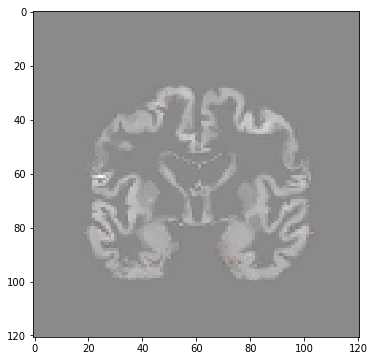

In [14]:
#saliency maps

for i in range(0,23,2):
  plt.figure()
  a = test_img[:,i,:]
  a = np.rot90(a)
  a = np.fliplr(a)
  ab=test_img.reshape(121,23,121,1)
  #plt.suptitle('Sensitivity Analysis')
  salient=visualize_saliency(model,layer_idx,filter_indices=0,seed_input= ab)
  b = salient[:,i,:]
  b= np.rot90(b)
  b = np.fliplr(b)
  plt.imshow(a, cmap='gray')
  plt.imshow(b,cmap=cmap_AD,alpha = 0.5,vmin=0,vmax=1) #,vmin=0.3,vmax=1

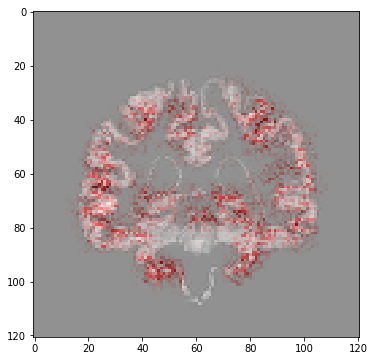

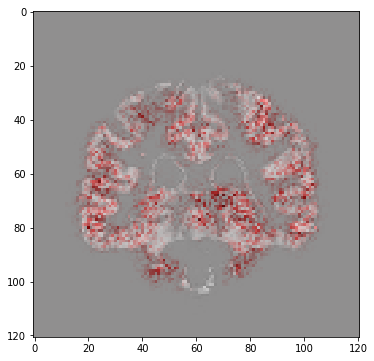

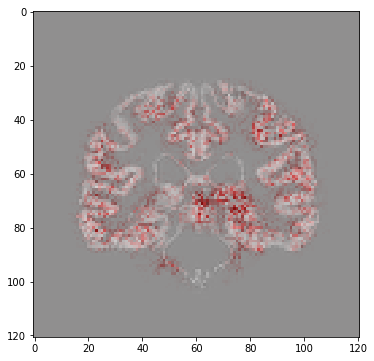

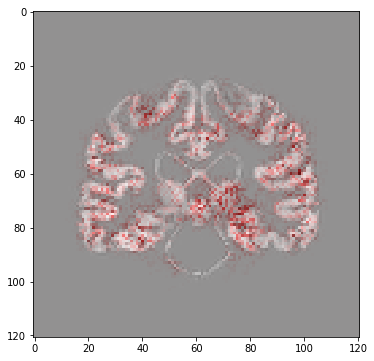

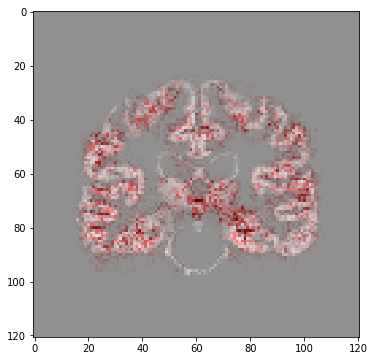

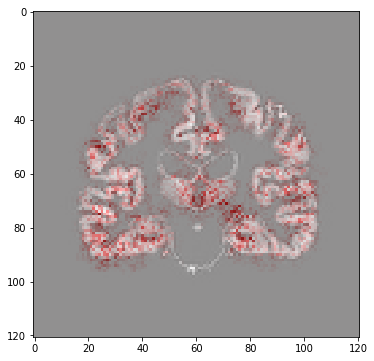

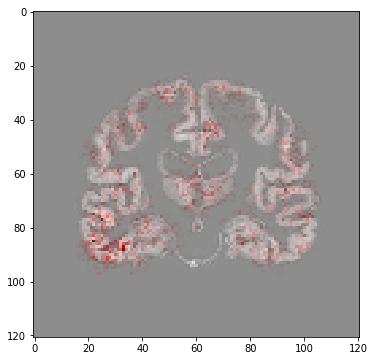

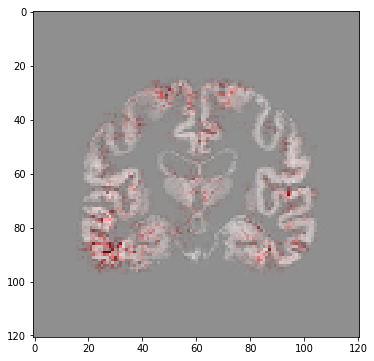

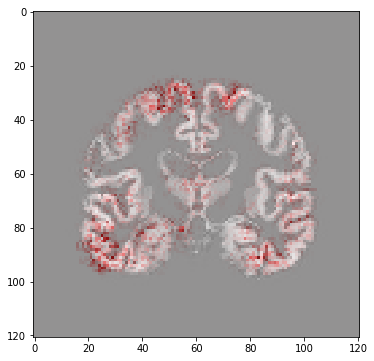

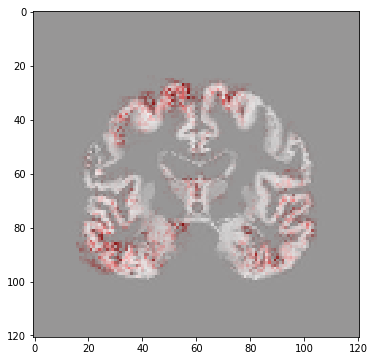

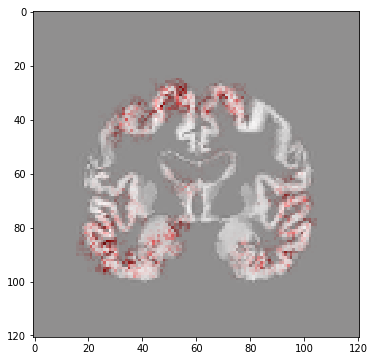

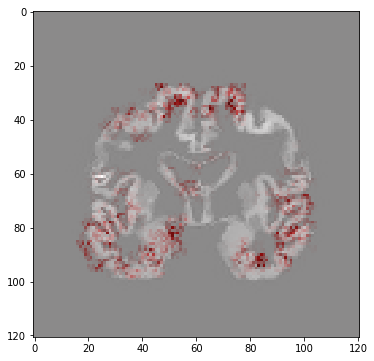

In [15]:
# guided back propogation
  
for i in range(0,23,2):
  plt.figure()
  a = test_img[:,i,:]
  a = np.rot90(a)
  a = np.fliplr(a)
  ab=test_img.reshape(121,23,121,1)
  #plt.suptitle('Guided Backpropagation')
  guided=visualize_saliency(model,layer_idx,filter_indices=0,seed_input= ab, backprop_modifier='guided')
  b = guided[:,i,:]
  b= np.rot90(b)
  b = np.fliplr(b)
  plt.imshow(a, cmap='gray')
  plt.imshow(b,cmap=cmap_AD,alpha = 0.5) #,vmin=0.3,vmax=1

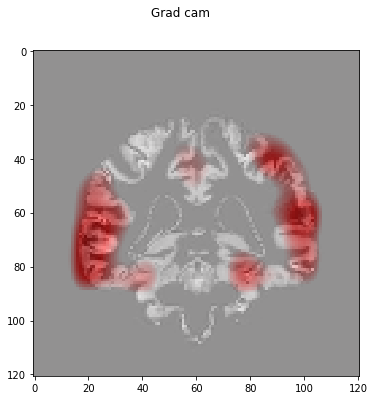

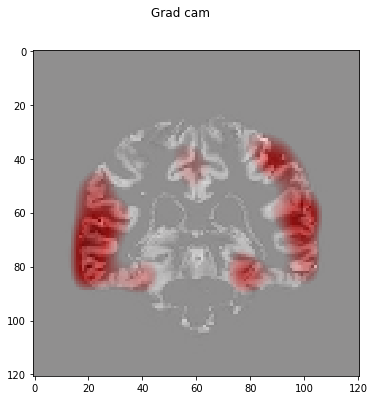

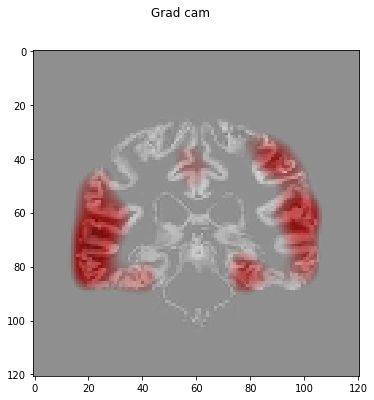

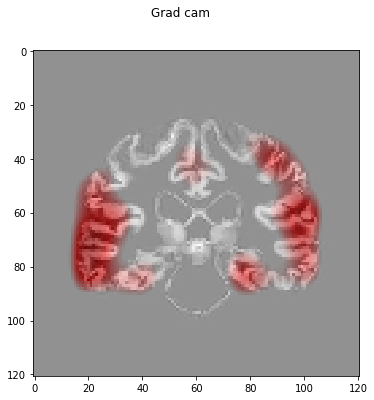

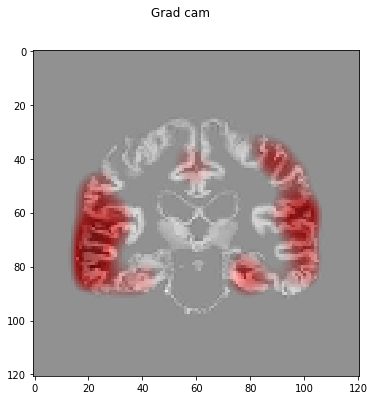

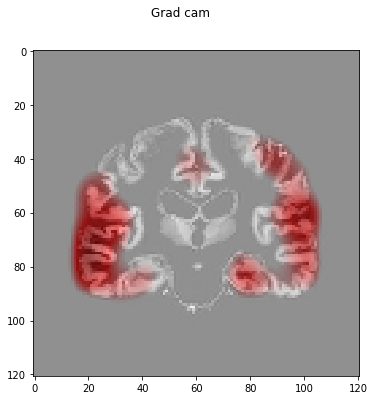

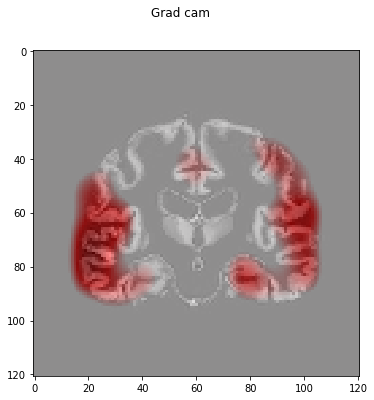

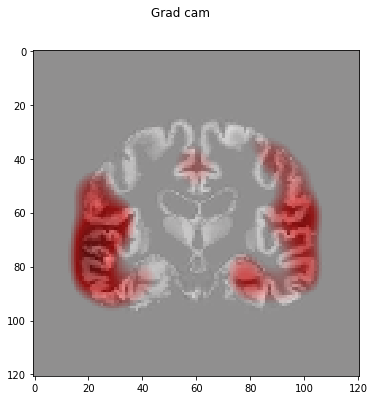

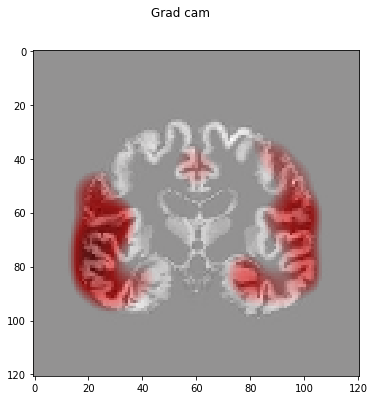

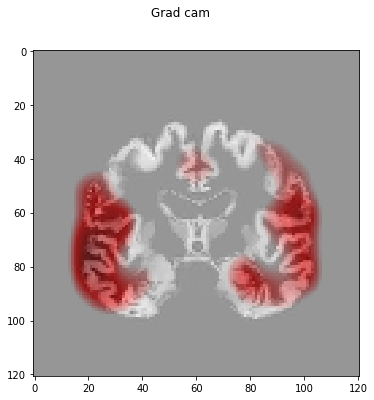

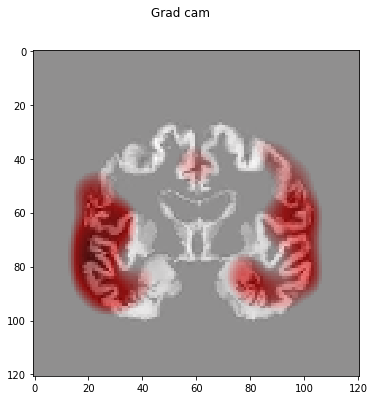

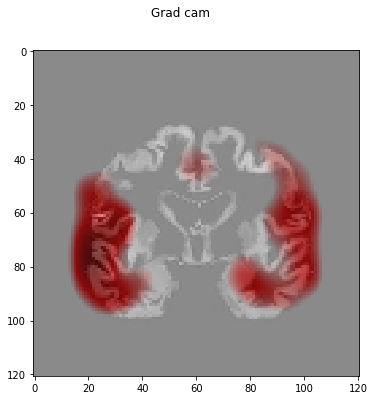

In [18]:
#Grad-CAM

for i in range(0,23,2):
  plt.figure()
  a = test_img[:,i,:]
  a = np.rot90(a)
  a = np.fliplr(a)
  ab=test_img.reshape(121,23,121,1)
  plt.suptitle('Grad cam')
  gradcam=visualize_cam(model,layer_idx,filter_indices=0,seed_input= ab, backprop_modifier='guided')
  b = gradcam[:,i,:]
  b= np.rot90(b)
  b = np.fliplr(b)
  plt.imshow(a, cmap='gray')
  plt.imshow(b,cmap=cmap_AD,alpha = 0.5,vmin=0.4,vmax=1) #,vmin=0.3,vmax=1



In [0]:
#saliency maps
gg = glob.glob('AD_CN_380/*')
for f in range(len(gg)):
  results = [os.path.basename(f) for f in glob.glob(os.path.join('AD_CN_380', '*.nii'))]
  a = nib.load(gg[f])
  a = a.get_data()
  a = a[:,57:80,:]
  a = np.nan_to_num(a)       # normalising to (0-1) and then normalising to 0 mean and 1 std
  m = np.max(a)
  mi = np.min(a)
  a = (a - mi) / (m - mi)
  a = (a - a.mean())/a.std()
  for i in range(0,23,2):
    #plt.figure()
    b = a[:,i,:]
    
    img = a.reshape(121,23,121,1)
    b = np.rot90(b)
    b = np.fliplr(b)
    if('mwp1HC' in os.path.basename(gg[f])):
      salient=visualize_saliency(model,layer_idx,filter_indices=0,seed_input= img)
    else:
      salient=visualize_saliency(model,layer_idx,filter_indices=1,seed_input= img)
    c = salient[:,i,:]
    c= np.rot90(c)
    c = np.fliplr(c)
    plt.imshow(b, cmap='gray')
    plt.imshow(c,cmap=cmap_AD,alpha = 0.5) #,vmin=0.3,vmax=1
    plt.savefig('pics/3D_Saliency_slice_' + str(i) + '_' + (results[f].split('.')[0].split('_MR')[0])) 
    #plt.savefig('pics/3D_Saliency_slice_' + str(i) + '_' + (results[f].split('.')[0]))  

In [0]:
#saving guided backpropagation maps
gg = glob.glob('AD_CN_380/*')
for f in range(len(gg)):
  results = [os.path.basename(f) for f in glob.glob(os.path.join('AD_CN_380', '*.nii'))]
  a = nib.load(gg[f])
  a = a.get_data()
  a = a[:,57:80,:]
  a = np.nan_to_num(a)       # normalising to (0-1) and then normalising to 0 mean and 1 std
  m = np.max(a)
  mi = np.min(a)
  a = (a - mi) / (m - mi)
  a = (a - a.mean())/a.std()
  for i in range(0,23,2):
    #plt.figure()
    b = a[:,i,:]
    img = a.reshape(121,23,121,1)
    b = np.rot90(b)
    b = np.fliplr(b)
    if('mwp1HC' in os.path.basename(gg[f])):
      guided=visualize_saliency(model,layer_idx,filter_indices=0,seed_input= img, backprop_modifier='guided')
    else:
      guided=visualize_saliency(model,layer_idx,filter_indices=1,seed_input= img, backprop_modifier='guided')
    c = guided[:,i,:]
    c= np.rot90(c)
    c = np.fliplr(c)
    plt.imshow(b, cmap='gray')
    plt.imshow(c,cmap=cmap_AD,alpha = 0.5) #,vmin=0.3,vmax=1
    plt.savefig('pics/3D_GBP_slice_' + str(i) + '_' + (results[f].split('.')[0].split('_MR')[0])) 
    #plt.savefig('pics/3D_GBP_slice_' + str(i) + '_' + (results[f].split('.')[0]))  

In [0]:
#saving Grad CAM maps
gg = glob.glob('AD_CN_380/*')
for f in range(len(gg)):
  results = [os.path.basename(f) for f in glob.glob(os.path.join('AD_CN_380', '*.nii'))]
  a = nib.load(gg[f])
  a = a.get_data()
  a = a[:,57:80,:]
  a = np.nan_to_num(a)       # normalising to (0-1) and then normalising to 0 mean and 1 std
  m = np.max(a)
  mi = np.min(a)
  a = (a - mi) / (m - mi)
  a = (a - a.mean())/a.std()
  for i in range(0,23,2):
    #plt.figure()
    b = a[:,i,:]
    img = a.reshape(121,23,121,1)
    b = np.rot90(b)
    b = np.fliplr(b)
    if('mwp1HC' in os.path.basename(gg[f])):
      gradcam=visualize_cam(model,layer_idx,filter_indices=0,seed_input= img, backprop_modifier='guided')
    else:
      gradcam=visualize_cam(model,layer_idx,filter_indices=1,seed_input= img, backprop_modifier='guided')
    c = gradcam[:,i,:]
    c= np.rot90(c)
    c = np.fliplr(c)
    plt.imshow(b, cmap='gray')
    plt.imshow(c,cmap=cmap_AD,alpha = 0.5,vmin=0.3,vmax=1)
    plt.savefig('pics/3D_GradCAM_slice_' + str(i) + '_' + (results[f].split('.')[0].split('_MR')[0])) 
    #plt.savefig('pics/3D_GradCAM_slice_' + str(i) + '_' + (results[f].split('.')[0]))  

In [1]:
!tar -cvf pics.tar pics/

pics/
pics/3D_Saliency_slice_6_mwp1MCI_4366_011.png
pics/3D_Saliency_slice_10_mwp1AD_4494_126.png
pics/3D_Saliency_slice_4_mwp1HC_4224_082.png
pics/3D_Saliency_slice_16_mwp1AD_4696_018.png
pics/3D_Saliency_slice_8_mwp1MCI_4029_031.png
pics/3D_Saliency_slice_12_mwp1HC_4422_129.png
pics/3D_Saliency_slice_8_mwp1HC_4176_033.png
pics/3D_Saliency_slice_4_mwp1HC_4176_033.png
pics/3D_Saliency_slice_18_mwp1MCI_4394_072.png
pics/3D_Saliency_slice_14_mwp1HC_4340_068.png
pics/3D_Saliency_slice_4_mwp1AD_4583_016.png
pics/3D_Saliency_slice_22_mwp1AD_4625_116.png
pics/3D_Saliency_slice_4_mwp1HC_4357_006.png
pics/3D_Saliency_slice_4_mwp1MCI_4240_127.png
pics/3D_Saliency_slice_10_mwp1AD_4583_016.png
pics/3D_Saliency_slice_18_mwp1AD_4353_016.png
pics/3D_Saliency_slice_2_mwp1MCI_4456_141.png
pics/3D_Saliency_slice_0_mwp1MCI_4842_128.png
pics/Sensitivity_2D_slice4_mwp1MCI_4722_135.png
pics/3D_Saliency_slice_16_mwp1MCI_4741_009.png
pics/3D_Saliency_slice_2_mwp1MCI_4562_036.png
pics/3D_Saliency_slice_16_mwp

In [0]:
rm -rf pics

In [0]:
!mkdir pics

In [0]:
gg = glob.glob('AD_CN_380/*')
for f in range(len(gg)):
  results = [os.path.basename(f) for f in glob.glob(os.path.join('AD_CN_380', '*.nii'))]

In [16]:
results[1].split('.')[0].split('_MR')[0]

'mwp1MCI_4456_141'